# SSAM Notebook: Multiplexed smFISH SSAM analysis

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar

from sklearn import preprocessing
import pickle
import numpy as np

from shapely.geometry import Point, Polygon

In [74]:
cell_class_colors = {
    "Astro": "#665C47",
    "CR": "#00FF66",
    "Endo": "#8D6C62",
    "L2/3 IT": "#94D9A1",
    "L4": "#00979D",
    "Lamp5": "#DA808C",
    "L5 IT": "#008A61",
    "L5 NP": "#3E9E64",
    "L5 PT": "#0D5B78",
    "L6 PT": "#69A8E6",
    "L6 CT": "#69A8E6",
    "L6 IT": "#A19922",
    "L6b": "#266180",
    "Macrophage": "#537358",
    "Meis2": "#FF0000",
    "Oligo": "#53776C",
    "Peri": "#665547",
    "Pvalb": "#D93137",
    "Serpinf1": "#8510C0",
    "SMC": "#807059",
    "Sncg": "#8510C0",
    "Sst": "#F15A29",
    "VLMC": "#697255",
    "Vip": "#70559A",
}

In [196]:
seg_df = pd.read_csv("data/baysor/allen_smfish/segmentation.csv")

In [202]:
import pandas as pd
spots = pd.read_csv("data/raw/smFISH_MCT_CZI_Panel_0_spot_table.csv", usecols=["x", "y", "target"]).rename(columns={"target": "gene"}).set_index('gene')
spots['cell'] = seg_df['cell'].to_numpy()
um_per_pixel = 0.1
spots.x = spots.x*um_per_pixel
spots.y = spots.y*um_per_pixel
spots.x -= spots.x.min()
spots.y -= spots.y.min()

In [205]:
import json
with open("spacejam2/data/annotations/Allen_smFISH_annotations_geo.json") as f:
    annotations = json.load(f)['geometries'][0]
p = Polygon(annotations["coordinates"][0])
spots['layers'] = ["VISp" if p.intersects(Point(a)) else "outside_VISp" for a in spots[["x","y"]].values]

In [206]:
spots = pd.DataFrame(spots[spots['layers'] == 'VISp'])

In [208]:
beta = 3.65568224985292
rotm = np.array([[np.cos(beta), np.sin(beta)], [-np.sin(beta), np.cos(beta)]])
pos_um = np.array([spots.x, spots.y])
rot_um = np.dot(pos_um.T, rotm)
rot_um[:, 0] -= np.min(rot_um[:, 0])
rot_um[:, 1] -= np.min(rot_um[:, 1])

In [209]:
spots.x = rot_um[:, 0]
spots.y = rot_um[:, 1]

In [210]:
spots

x           y  cell layers
gene                                       
Fezf2  1315.182205  819.217163  1605   VISp
Fezf2  1320.888600  849.389891  2496   VISp
Fezf2  1312.216275  828.169190  1605   VISp
Fezf2  1326.185386  826.385356  1041   VISp
Fezf2  1311.445646  830.360813  1605   VISp
...            ...         ...   ...    ...
Parm1   138.048814  405.155912  2822   VISp
Parm1   134.461634  507.451830   407   VISp
Parm1   152.472339  434.736509  4354   VISp
Parm1   126.271979  403.504210  3478   VISp
Parm1   138.543595  457.197028   999   VISp

[640082 rows x 4 columns]

In [60]:
import ssam

In [61]:
ds = ssam.SSAMDataset("ssam_data/msmfish")
analysis = ssam.SSAMAnalysis(ds, ncores=10, verbose=True)

In [62]:
width = int(spots.x.max())
height = int(spots.y.max())
analysis.run_kde(locations=spots, width=width, height=height, bandwidth=2.5)

Running KDE for gene Alcam...
Saving KDE for gene Alcam...
Running KDE for gene Chodl...
Saving KDE for gene Chodl...
Running KDE for gene Cux2...
Saving KDE for gene Cux2...
Running KDE for gene Fezf2...
Saving KDE for gene Fezf2...
Running KDE for gene Foxp2...
Saving KDE for gene Foxp2...
Running KDE for gene Gad2...
Saving KDE for gene Gad2...
Running KDE for gene Galnt14...
Saving KDE for gene Galnt14...
Running KDE for gene Grin3a...
Saving KDE for gene Grin3a...
Running KDE for gene Kcnip4...
Saving KDE for gene Kcnip4...
Running KDE for gene Kcnk2...
Saving KDE for gene Kcnk2...
Running KDE for gene Lhx6...
Saving KDE for gene Lhx6...
Running KDE for gene Mpped1...
Saving KDE for gene Mpped1...
Running KDE for gene Parm1...
Saving KDE for gene Parm1...
Running KDE for gene Pde1a...
Saving KDE for gene Pde1a...
Running KDE for gene Prox1...
Saving KDE for gene Prox1...
Running KDE for gene Pvalb...
Saving KDE for gene Pvalb...
Running KDE for gene Rorb...
Saving KDE for gene Ror

In [65]:
exp_thres = 0.027
norm_thres = 0.2

In [67]:
analysis.find_localmax(search_size=3)

Found 5081 local max vectors.


In [68]:
analysis.normalize_vectors()

Normalizing...
Processing chunk 1 (of 1)...


In [69]:
cell_by_gene = pd.read_csv("data/jeremy_filtered/smFISH_filtered_cellxgene.csv")
cell_by_gene = cell_by_gene.set_index('gene_name').T[ds.genes]

In [130]:
cell_by_gene

gene_name  Alcam  Chodl  Cux2  Fezf2  Foxp2  Gad2  Galnt14  Grin3a  Kcnip4  \
1              0      0     0     15     20     0        0       1       0   
5              4      1    20      3      1     3        2       0       1   
6             36      1    39      1      1     0        1       0       2   
7             32      1    37      2      1     0        0       1       1   
9             66      0    19      2      0    75        0       0       0   
...          ...    ...   ...    ...    ...   ...      ...     ...     ...   
4664          19      1    42      2      2     1        0       0       1   
4665           0      0     0     15     21     1        0       0       0   
4669          57     10     6      9      5    65       23      50       4   
4670           7      0     6      0      0     0        0       0       0   
4690           0      0     0      2      6     0        0       0       0   

gene_name  Kcnk2  ...  Parm1  Pde1a  Prox1  Pvalb  Rorb  Satb2  Sema3e  Sez6  \
1             30  ...      0     16      0      1     0      9       4    12   
5             39  ...      1     10      2      3    52     32       2     6   
6              3  ...      0      6      1      1     2     24       1     6   
7              8  ...      2     20      1      2     2     18       2     7   
9              6  ...      6      1      0    255     7      1       1     3   
...          ...  ...    ...    ...    ...    ...   ...    ...     ...   ...   
4664           3  ...      1     32      1      0     2     13       0    19   
4665          32  ...      0     39      0      3     0     11      15    28   
4669          18  ...      6      4      4      6     2      4      20     8   
4670          15  ...      0      0      0      1    23     20       0     2   
4690          12  ...      0     12      0      1     0      3       2     4   

gene_name  Sv2c  Thsd7a  
1             0       0  
5             1       2  
6             1       1  
7             0       1  
9             0      18  
...         ...     ...  
4664          0       2  
4665          0       0  
4669          7       6  
4670          0       1  
4690          0       0  

[2360 rows x 22 columns]

In [70]:
from sklearn.preprocessing import normalize
#cell_by_gene_normalized = ssam.run_sctransform(cell_by_gene.reset_index(drop=True), plot_model_pars=True)[0]
cell_by_gene_normalized = np.log(normalize(cell_by_gene, norm="l1", axis=1) * 10 + 1)

In [87]:
calls_nwcs = pd.read_csv("consensus_calls/renee/smFISH_filtered_combined_mapping_neg_weight_subclass.csv")

In [101]:
uniq_celltypes_nwcs = list(calls_nwcs.subclass.unique())
centroids_nwcs = []
for cell_type in uniq_celltypes_nwcs:
    centroids_nwcs.append(np.mean(cell_by_gene_normalized[calls_nwcs.subclass == cell_type], axis=0))

In [273]:
analysis.map_celltypes(centroids_nwcs)

Generating cell-type map for centroid #0...
Processing chunk (0/1)...
Generating cell-type map for centroid #1...
Processing chunk (0/1)...
Generating cell-type map for centroid #2...
Processing chunk (0/1)...
Generating cell-type map for centroid #3...
Processing chunk (0/1)...
Generating cell-type map for centroid #4...
Processing chunk (0/1)...
Generating cell-type map for centroid #5...
Processing chunk (0/1)...
Generating cell-type map for centroid #6...
Processing chunk (0/1)...
Generating cell-type map for centroid #7...
Processing chunk (0/1)...
Generating cell-type map for centroid #8...
Processing chunk (0/1)...
Generating cell-type map for centroid #9...
Processing chunk (0/1)...
Generating cell-type map for centroid #10...
Processing chunk (0/1)...
Generating cell-type map for centroid #11...
Processing chunk (0/1)...
Generating cell-type map for centroid #12...
Processing chunk (0/1)...
Generating cell-type map for centroid #13...
Processing chunk (0/1)...
Generating cell-

In [274]:
analysis.filter_celltypemaps(min_norm=0.4, min_r=0.6)

In [271]:
map_colors_nwcs = [cell_class_colors[ct] for ct in uniq_celltypes_nwcs]

Text(0.5, 1.0, 'Multiplexed smFISH - NWCS (SSAM)')

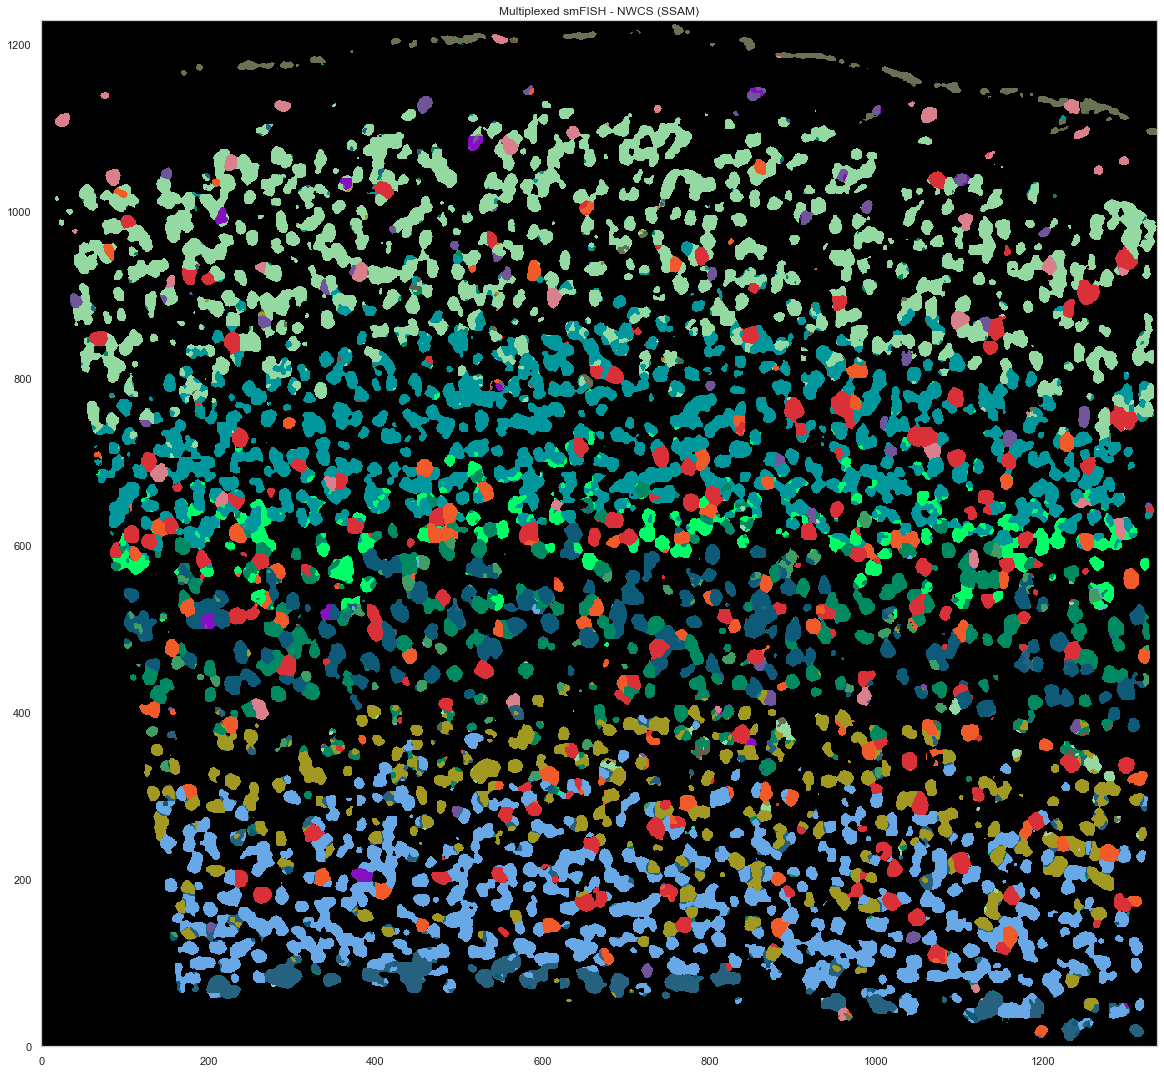

In [275]:
plt.figure(figsize=[20, 20])
ds.plot_celltypes_map(rotate=3, colors=map_colors_nwcs)
plt.title("Multiplexed smFISH - NWCS (SSAM)")

In [92]:
calls_gmcs = pd.read_csv("consensus_calls/charles/smfish_jeremy_pciseq_renee_eeshit_gabriele_consensus_df.csv")

In [93]:
uniq_celltypes_gmcs = list(calls_gmcs.subclass.unique())
centroids_gmcs = []
for cell_type in uniq_celltypes_gmcs:
    centroids_gmcs.append(np.mean(cell_by_gene_normalized[calls_gmcs.subclass == cell_type], axis=0))

In [94]:
analysis.map_celltypes(centroids_gmcs)

Generating cell-type map for centroid #0...
Processing chunk (0/1)...
Generating cell-type map for centroid #1...
Processing chunk (0/1)...
Generating cell-type map for centroid #2...
Processing chunk (0/1)...
Generating cell-type map for centroid #3...
Processing chunk (0/1)...
Generating cell-type map for centroid #4...
Processing chunk (0/1)...
Generating cell-type map for centroid #5...
Processing chunk (0/1)...
Generating cell-type map for centroid #6...
Processing chunk (0/1)...
Generating cell-type map for centroid #7...
Processing chunk (0/1)...
Generating cell-type map for centroid #8...
Processing chunk (0/1)...
Generating cell-type map for centroid #9...
Processing chunk (0/1)...
Generating cell-type map for centroid #10...
Processing chunk (0/1)...
Generating cell-type map for centroid #11...
Processing chunk (0/1)...
Generating cell-type map for centroid #12...
Processing chunk (0/1)...
Generating cell-type map for centroid #13...
Processing chunk (0/1)...


In [98]:
analysis.filter_celltypemaps(min_norm=0.4, min_r=0.6)

In [96]:
map_colors_gmcs = [cell_class_colors[ct.replace("_", " ").replace("L23", "L2/3")] for ct in uniq_celltypes_gmcs]

Text(0.5, 1.0, 'Multiplexed smFISH - GMCS (SSAM)')

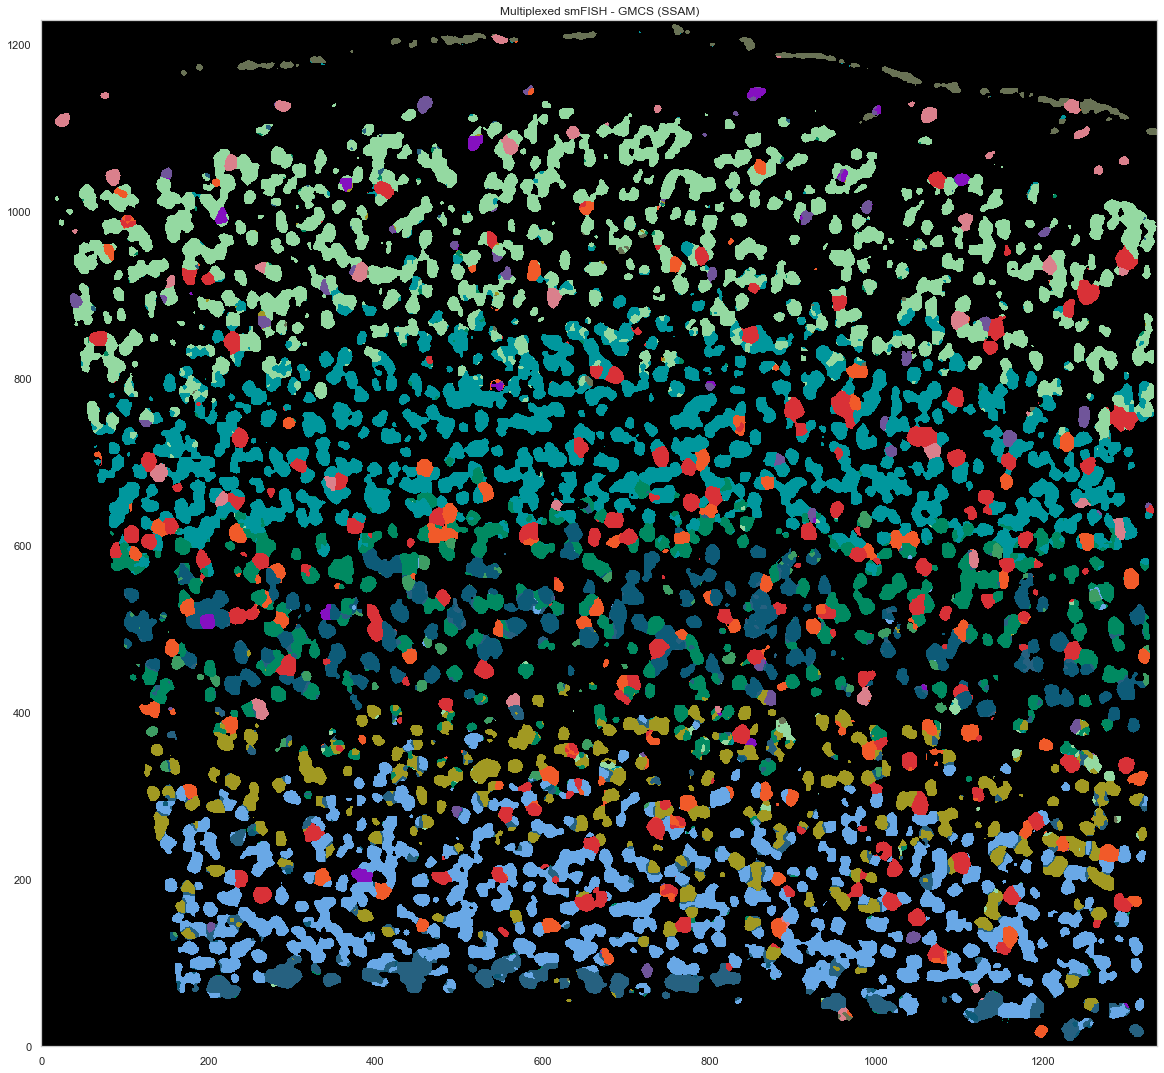

In [269]:
plt.figure(figsize=[20, 20])
ds.plot_celltypes_map(rotate=3, z=0, colors=map_colors_gmcs)
plt.title("Multiplexed smFISH - GMCS (SSAM)")

In [102]:
closest_nwcs_clusters = []
closest_nwcs_clusters_r = []
closest_gmcs_clusters = []
closest_gmcs_clusters_r = []
for v in ds.normalized_vectors:
    corrs = [ssam.utils.corr(v, centroids_nwcs[i]) for i in range(len(centroids_nwcs))]
    idx = np.argmax(corrs)
    closest_nwcs_clusters.append(uniq_celltypes_nwcs[idx])
    closest_nwcs_clusters_r.append(corrs[idx])
    
    corrs = [ssam.utils.corr(v, centroids_gmcs[i]) for i in range(len(centroids_gmcs))]
    idx = np.argmax(corrs)
    closest_gmcs_clusters.append(uniq_celltypes_gmcs[idx])
    closest_gmcs_clusters_r.append(corrs[idx])
    
df = pd.DataFrame(ds.normalized_vectors, columns=ds.genes)
df.to_csv("smfish_ssam_localmax_expression.csv")

df = pd.DataFrame()
df['x'] = ds.local_maxs[0]
df['y'] = ds.local_maxs[1]
df['closest_consensus_nwcs_cluster'] = closest_nwcs_clusters
df['closest_consensus_nwcs_cluster_r'] = closest_nwcs_clusters_r
df['closest_consensus_gmcs_cluster'] = closest_gmcs_clusters
df['closest_consensus_gmcs_cluster_r'] = closest_gmcs_clusters_r

df.to_csv("smfish_ssam_localmax_metadata.csv")

In [190]:
seg_df

x             y   gene  molecule_id  prior_segmentation  \
0          810.126860   9292.386457  Fezf2            1                   0   
1         1943.257062   9727.200624  Fezf2            2                   0   
2         2801.555251  12527.203611  Fezf2            3                   0   
3         3917.429347  11999.575628  Fezf2            4                3143   
4         2755.021020  13640.961815  Fezf2            5                3246   
...               ...           ...    ...          ...                 ...   
1074773  21673.460029   9583.192477  Parm1      1074774                2095   
1074774  22006.806014   9043.561139  Parm1      1074775                2199   
1074775  22638.107108   9538.205623  Parm1      1074776                3299   
1074776  21972.860739   8635.078032  Parm1      1074777                2198   
1074777  23424.790973   8475.150266  Parm1      1074778                   0   

         confidence  cluster  cell  assignment_confidence  is_noise  
0           0.00000        4     0                    1.0      True  
1           0.00000        4     0                    1.0      True  
2           0.99997        1  4516                    1.0     False  
3           1.00000        5  1605                    1.0     False  
4           1.00000        5  4558                    1.0     False  
...             ...      ...   ...                    ...       ...  
1074773     0.99997        1   481                    1.0     False  
1074774     0.99997        4  1918                    1.0     False  
1074775     0.99999        4  3113                    1.0     False  
1074776     1.00000        1  3924                    1.0     False  
1074777     0.99995        3   186                    1.0     False  

[1074778 rows x 10 columns]

Text(0.5, 1.0, 'Multiplexed smFISH - NWCS')

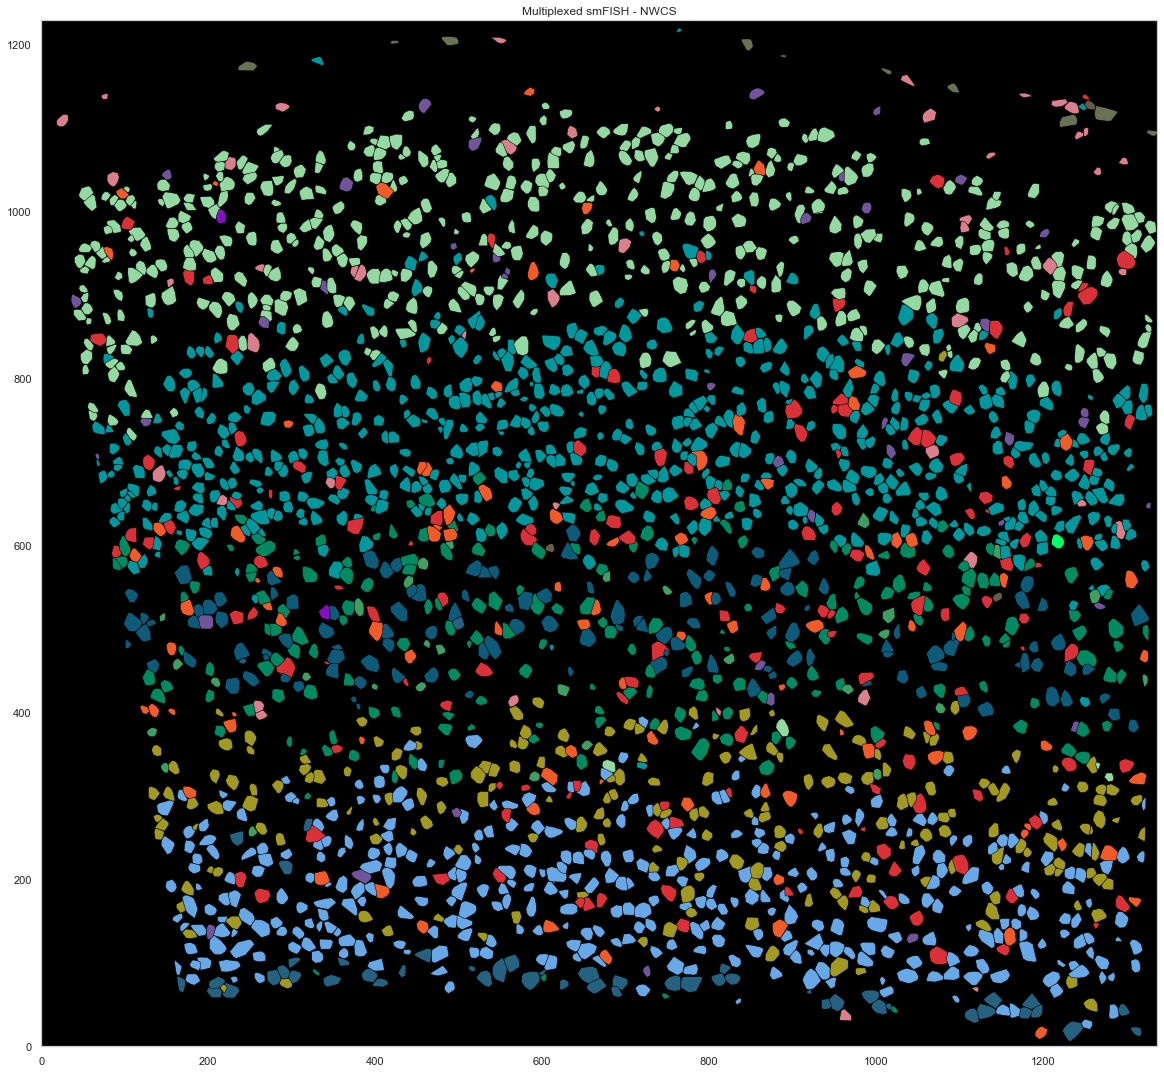

In [267]:
from scipy.spatial import ConvexHull

plt.figure(figsize=[20, 20])
plt.gca().set_facecolor('black')
good_ids = cell_by_gene.index.astype(int)
i = 0
for cid, sdf in spots.groupby("cell"):
    if cid in good_ids:
        points = sdf.iloc[:, :2].to_numpy()
        hull = ConvexHull(points)
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], cell_class_colors[calls_nwcs.subclass[i]], edgecolor="black", linewidth=0.5)
        i += 1
plt.xlim([0, ds.shape[0]])
plt.ylim([0, ds.shape[1]])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Multiplexed smFISH - NWCS")

Text(0.5, 1.0, 'Multiplexed smFISH - GMCS')

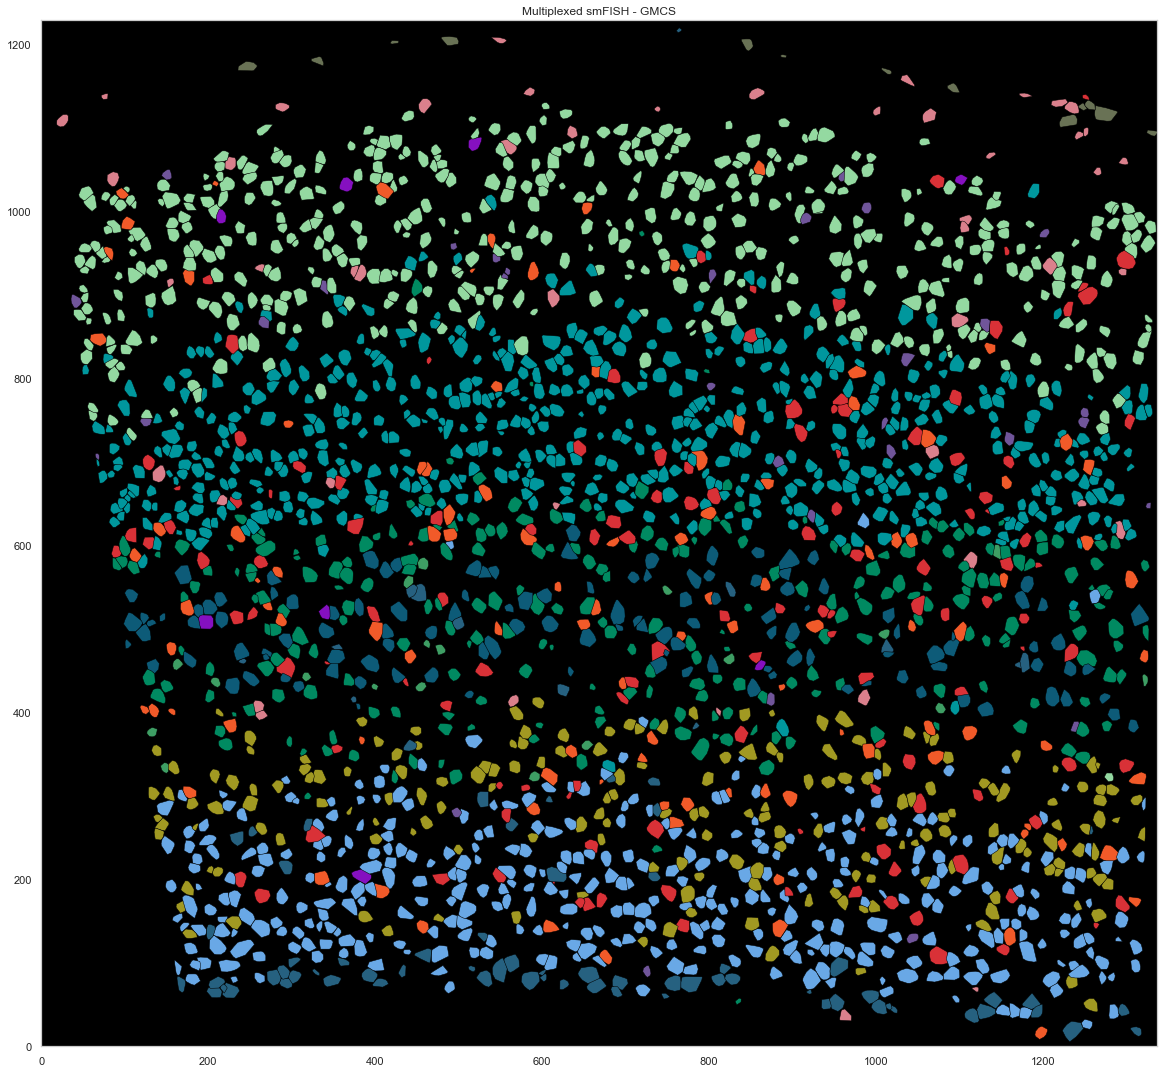

In [268]:
from scipy.spatial import ConvexHull

plt.figure(figsize=[20, 20])
plt.gca().set_facecolor('black')
good_ids = cell_by_gene.index.astype(int)
i = 0
for cid, sdf in spots.groupby("cell"):
    if cid in good_ids:
        points = sdf.iloc[:, :2].to_numpy()
        hull = ConvexHull(points)
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], cell_class_colors[calls_gmcs.subclass[i].replace("_", " ").replace("L23", "L2/3")], edgecolor="black", linewidth=0.5)
        i += 1
plt.xlim([0, ds.shape[0]])
plt.ylim([0, ds.shape[1]])
plt.gca().set_aspect('equal', adjustable='box')

plt.title("Multiplexed smFISH - GMCS")